In [86]:
import numpy as np
import pandas as pd
import os
import skimage
import imageio
from skimage import io
from skimage import img_as_float
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.metrics import roc_auc_score, f1_score
from os import listdir
from skimage import io, transform, util, img_as_float
from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback
from fastnumbers import fast_real
from keras import Sequential
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm
%matplotlib inline

In [87]:
def txt2arrUseDest (path):
    LinesCenters = []
    f = open(path, 'r', encoding='utf-16')
    line = f.readline()
    while line:
        line = f.readline()
        #print (len(line))
        if len(line) != 0 and len(line) != 1:
            num1 = line.split("	")[0]
            #print('num1 = ' + num1)
            num2 = line.split("	")[1].split("\n")[0]
            #print('num2 = ' + num2)
            LinesCenters.append((int(num1)+ int(num2))//2)
    f.close()
    
    res = np.zeros(3508)
    i = 0
    #print (len(LinesCenters))                           
    for k in range(len(LinesCenters)):
        if k == 0:
            curDist = LinesCenters[0]
            while i<= LinesCenters[0]:  
                res[i] = int(curDist)
                i+= 1                        
                curDist -= 1 
        elif k == len(LinesCenters) - 1:
            
            curDist = 1
            while i < 3508:
                res[i] = int(curDist)
                curDist += 1
                i += 1
        else:
            while i < LinesCenters[k+1]:
                res[i] = int( min (abs(LinesCenters[k-1]-i),abs(LinesCenters[k]-i)))
                i += 1
                                
    return res

In [88]:
dests = txt2arrUseDest ('train_txt/582.txt')
for i in range (len(dests)):
    print(dests[i])

321.0
320.0
319.0
318.0
317.0
316.0
315.0
314.0
313.0
312.0
311.0
310.0
309.0
308.0
307.0
306.0
305.0
304.0
303.0
302.0
301.0
300.0
299.0
298.0
297.0
296.0
295.0
294.0
293.0
292.0
291.0
290.0
289.0
288.0
287.0
286.0
285.0
284.0
283.0
282.0
281.0
280.0
279.0
278.0
277.0
276.0
275.0
274.0
273.0
272.0
271.0
270.0
269.0
268.0
267.0
266.0
265.0
264.0
263.0
262.0
261.0
260.0
259.0
258.0
257.0
256.0
255.0
254.0
253.0
252.0
251.0
250.0
249.0
248.0
247.0
246.0
245.0
244.0
243.0
242.0
241.0
240.0
239.0
238.0
237.0
236.0
235.0
234.0
233.0
232.0
231.0
230.0
229.0
228.0
227.0
226.0
225.0
224.0
223.0
222.0
221.0
220.0
219.0
218.0
217.0
216.0
215.0
214.0
213.0
212.0
211.0
210.0
209.0
208.0
207.0
206.0
205.0
204.0
203.0
202.0
201.0
200.0
199.0
198.0
197.0
196.0
195.0
194.0
193.0
192.0
191.0
190.0
189.0
188.0
187.0
186.0
185.0
184.0
183.0
182.0
181.0
180.0
179.0
178.0
177.0
176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.0
157.0
156.0
155.

15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0


In [104]:
def getCentersFiltered (arr, delta):
    res = []
    for k in range(len(arr)):
        if arr[k] < delta:
            res.append(k)
    #i = 1
    #while i < len(res):
    #    print (abs(res[i] - res[i-1]))
    #    if abs(res[i] - res[i-1]) <= delta+2:
    #        res.remove(res[i-1])
    #    i += 1
    return np.array(res)
centers = getCentersFiltered(dests, 2)
print(centers)

[ 320  321  322  375  376  377  428  429  481  482  532  533  584  585
  635  636  685  686  738  739  790  791  841  842  893  894  945  946
  997  998 1049 1050 1101 1102 1153 1154 1205 1206 1257 1258 1309 1310
 1361 1362 1413 1414 1465 1466 1517 1518 1569 1570 1621 1622 1673 1674
 1725 1726 1777 1778 1829 1830 1881 1882 1933 1934 1985 1986 2037 2038
 2090 2091 2141 2142 2193 2194 2245 2246 2297 2298 2349 2350 2401 2402
 2453 2454 2505 2506 2557 2558 2609 2610 2661 2662 2713 2714 2765 2766
 2817 2818 2869 2870 2921 2922 2973 2974 3025 3026 3077 3078 3129 3130
 3190]


In [100]:
def shapeA4 (img):
    padded_img = np.zeros((3508, 2480))
    #padded_img[:img.shape[0], :img.shape[1]] = img
    padded_img = img[:3508,:2480]
    return padded_img

In [68]:
n_train_samples = 89
n_test_samples = 24
n_labels = 2
kernel_first = 5
kernel_second = 7
h = 3508#1760 #3520 #3508 #1754
w = 2480#1248 #2496 #2480 #1240

In [65]:
for i, filename in tqdm(enumerate(os.listdir('train_img/')[:n_train_samples])):
    onlyName = filename.split('.')[0]
    img = skimage.io.imread('train_img/' + filename)
    x_arr = img / 255.0
    y_arr = txt2arrUseDest('train_txt/' + onlyName + '.txt')   

    
    np.savez_compressed('saved/train/' + onlyName + '.npz', x=x_arr, y=y_arr) 


12it [00:09,  1.22it/s]/home/ivan/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
80it [01:03,  1.26it/s]


In [66]:
for i, filename in tqdm(enumerate(os.listdir('test_img/')[:n_test_samples])):
    onlyName = filename.split('.')[0]
    img = skimage.io.imread('test_img/' + filename)
    x_arr = img / 255.0
    y_arr = txt2arrUseDest('test_txt/' + onlyName + '.txt')
    
    np.savez_compressed('saved/test/' + onlyName + '.npz', x=x_arr, y=y_arr) 

11it [00:09,  1.19it/s]/home/ivan/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
20it [00:16,  1.20it/s]


In [67]:
def img_generator(directory, batch_size):
    filenames = os.listdir(directory)
    while True:
        n_iter = len(filenames) // batch_size
        residual = len(filenames) % batch_size
        for i in range(n_iter):
            size = batch_size
            if (i == n_iter - 1) and (residual > 0):
                size = residual
            X = np.zeros((batch_size, h, w, 1))
            y = np.zeros((batch_size, h))
            for j in range(size):
                X[j] = np.load(directory + filenames[i * batch_size + j])['x'].reshape((h, w, 1))
                y[j] = np.load(directory + filenames[i * batch_size + j])['y']
            yield X, y

In [69]:
autoencoder = Sequential()
encoding_layers = [
    Convolution2D(8, kernel_first, kernel_first, border_mode='same', input_shape=( 3508, 2480, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((4,4)),
#    
    Convolution2D(16, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3,3)),
#    
    Convolution2D(16, kernel_second, kernel_second, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
#  
    Convolution2D(16, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
#    
    Convolution2D(4, kernel_first, kernel_first, border_mode='same'),
    BatchNormalization(),
    Activation('relu'),
]


for l in encoding_layers:
    autoencoder.add(l)
    #print(l.input_shape,l.output_shape,l)
autoencoder.add(Flatten())
autoencoder.add(Dense(3508, activation='sigmoid'))

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), input_shape=(3508, 248..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
  
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (7, 7), padding="same")`
  del sys.path[0]
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), padding="same")`
/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (5, 5), padding="same")`


In [70]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3508, 2480, 8)     208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 3508, 2480, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 3508, 2480, 8)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 877, 620, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 877, 620, 16)      3216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 877, 620, 16)      64        
_________________________________________________________________
activation_2 (Activation)    (None, 877, 620, 16)      0         
__________

In [71]:
gen = img_generator('saved/train/', 1)
x_, y_ = next(gen)

In [72]:
y_.shape

(1, 3508)

In [73]:
train_generator = img_generator('saved/train/', 2)
test_generator = img_generator('saved/test/', 2)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
autoencoder.fit_generator(train_generator, steps_per_epoch=100//5, epochs=6, validation_data=test_generator, validation_steps=4)

Epoch 1/6
20/20 [==============================] - 628s 31s/step - loss: 3893963.0938 - acc: 0.6250 - val_loss: 1485306.7188 - val_acc: 1.0000
Epoch 2/6
20/20 [==============================] - 729s 36s/step - loss: 2442985.3250 - acc: 0.9750 - val_loss: 1534892.8750 - val_acc: 1.0000
Epoch 3/6
14/20 [====================>.........] - ETA: 3:14 - loss: 2839320.4286 - acc: 1.0000

KeyboardInterrupt: 

In [74]:
autoencoder.save('temp/model-27-06.h5')
#autoencoder = load_model('temp/model.h5')

In [22]:
img = skimage.io.imread('train_img/102.jpg', as_grey=True)
normalized = img / 255.0
x_data = normalized[0:3508, 0:2480]
res = autoencoder.predict(x_data.reshape((1, h, w, 1)))

y_res = (res[:,:,0]).reshape((3508,))
y_lines = arr2lines(y_res)
#print(y_lines)

z_res = (res[:,:,1]).reshape((3508,))
z_lines = arr2lines(z_res)
#print(z_lines)

lines_res = np.array( y_res)
lines_res = np.tile(lines_res,(200,1))
lines_res = lines_res.transpose()

furigana_res = np.array( z_res)
furigana_res = np.tile(furigana_res,(200,1))
furigana_res = furigana_res.transpose()

res = np.concatenate((lines_res, img[:3508, :2480]), axis=1)
res = np.concatenate((res, furigana_res), axis=1)

imageio.imwrite('gradient.png', res)



/home/ivan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [2]:
def arr2lines(arr, delta = 5):
    size = len(arr)
    #фильтрация шума
    i = 0
    while (i+delta < size):
        sum = 0
        for k in range(delta):
            sum += arr[i+k]
        if (sum > delta/2):
            for k in range(delta):
                arr[i+k] = 1
        else:
            for k in range(delta):
                arr[i+k] = 0
        i+=delta
    while i<size:
        arr[i] = 0 
        i+=1
        
    #нахождение строк
    listLines = []
    i = 1
    prev = arr[0]
    cur = arr[1]
    while i < size:
        if prev != cur:
            listLines.append(i)
        prev = cur
        cur = arr[i]
        i+=1
    res = np.array(listLines)
    return res

In [ ]:
def vizual4arr (arr, width = 50):
    

In [59]:
A = np.array([1,2,3])
B = np.array([2,3,4])
result = np.abs(A-B).mean
print (result)

<built-in method mean of numpy.ndarray object at 0x7fbe98505710>


In [49]:
def getLinesFromFile (path):
    data = []
    f = open(path, 'r', encoding='utf-16')
    line = f.readline()
    while line:
        line = f.readline()
        if line.split("	")[0] != "" :
            num1 = line.split("	")[0]
            num2 = line.split("	")[1].split("\n")[0]
            data.append(fast_real(num1))
            data.append(fast_real(num2))
    f.close()
    res = np.array(data)
    return res

In [54]:
origLines = getLinesFromFile('test_txt/662.txt')[0:56]
print(origLines)
print(len(origLines))

[ 313  336  355  391  407  443  460  495  512  547  563  600  615  651
  668  703  719  756  771  808  823  859  876  912  927  963  979 1015
 1031 1067 1083 1119 1135 1171 1186 1223 1239 1275 1291 1327 1343 1379
 1395 1431 1447 1483 1499 1535 1552 1587 1603 1640 1656 1691 1707 1743]
56


In [60]:
def getMeanArrDiff (A, B):
    size = min (len(A), len(B))
    absSum = 0
    for i in range(size):
        absSum += abs (A[i] - B[i])
    return absSum/size

In [61]:
print (getMeanArrDiff (origLines, lines))

3.8214285714285716


In [66]:
def getArrDiff (A, B):
    size = min (len(A), len(B))
    absRes = []
    for i in range(size):
        absRes.append(abs(A[i] - B[i]))
    res =np.array(absRes)
    return res

(array([ 1.,  5., 22.,  3.,  0.,  1., 14.,  4.,  0.,  6.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

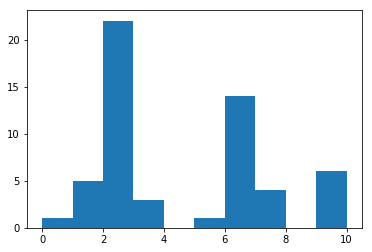

In [71]:
import matplotlib.pyplot as plt
plt.hist (getArrDiff(origLines, lines))

In [88]:
img = skimage.io.imread('train_img/4.jpg', as_grey=True)
normalized = img / 255.0
x_data = normalized[0:1754, 0:1240]
res = autoencoder.predict(x_data.reshape((1, h, w, 1)))

y_res = (res[:,:,0]).reshape((1754,))
y_lines = arr2lines(y_res)
print(y_lines)

z_res = (res[:,:,1]).reshape((1754,))
z_lines = arr2lines(z_res)
print(z_lines)

/home/ivan/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[  11   41   56   76   86  116  121  171  181  201  216  271  301  341
  356  406  426  476  491  536  556  601  621  656  681  726  746  826
  851  891  916  961  981 1016 1036 1086 1111 1491 1496 1546 1551 1596
 1601 1701 1706 1746]
[  21   41   56   76   91  111  121  146  186  206  251  271  301  341
  356  406  426  476  496  536  556  601  626  656  681  726  746  826
  851  891  916  961  981 1016 1036 1086 1116 1486 1491 1536 1541 1591
 1601 1696 1706]


In [3]:
from keras.models import load_model
autoencoder = load_model('model.h5')

In [12]:
img = skimage.io.imread('train_img/582.jpg', as_grey=True)
img.shape

(3508, 2480)

In [110]:
img = skimage.io.imread('test_img/662.jpg', as_grey=True)
normalized = img / 255.0
x_data = normalized
print (x_data)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [111]:
res = autoencoder.predict(x_data.reshape((1, 3508, 2480, 1)))
res = res.transpose()
for i in range (len(res)):
    print (res[i])


[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


[0.00046776]
[0.00043184]
[3.2348038e-07]
[7.4237937e-06]
[1.0789162e-06]
[0.00129672]
[0.00017705]
[0.00705572]
[0.00164208]
[0.00279868]
[0.00228297]
[0.00908105]
[0.07332789]
[0.04114482]
[0.00601254]
[0.00032202]
[0.00529005]
[0.01037653]
[2.3314868e-07]
[0.00392929]
[0.08191413]
[0.00055634]
[0.00038376]
[0.30739945]
[0.23096113]
[0.0002487]
[0.00416181]
[0.98508006]
[1.]
[0.04512581]
[0.03143666]
[1.]
[0.7526884]
[1.]
[1.]
[0.5217955]
[0.16040193]
[0.12357006]
[0.09993135]
[0.02092605]
[1.]
[0.01064697]
[1.]
[1.]
[1.087937e-35]
[2.8508262e-05]
[4.944665e-07]
[1.2616351e-07]
[1.5466092e-06]
[1.0896838e-06]
[2.867755e-08]
[2.1114515e-11]
[1.2431539e-05]
[0.00087482]
[0.00443731]
[1.6410662e-05]
[7.1715573e-07]
[0.01998213]
[0.00069941]
[0.00482991]
[0.00040888]
[0.00119703]
[0.02734607]
[7.2454004e-06]
[0.00266198]
[6.4269145e-05]
[0.00286145]
[1.]
[0.00185575]
[0.0057251]
[0.9998512]
[0.61576307]
[0.01307623]
[0.01309675]
[0.00092251]
[0.00037366]
[0.00803774]
[0.01134868]
[0.7241

[1.]
[1.]
[0.99999523]
[0.9999956]
[1.]
[1.]
[1.4943512e-10]
[2.1108484e-10]
[0.00015441]
[0.00072402]
[0.01566418]
[0.11213275]
[0.06832397]
[0.22395933]
[0.3654908]
[0.00548451]
[0.6112174]
[0.00207817]
[0.0314257]
[0.63010883]
[0.04601672]
[0.00124919]
[0.00754992]
[0.20445156]
[0.91510296]
[0.9982778]
[0.00134853]
[0.12647234]
[0.80612075]
[0.06676311]
[0.28592616]
[0.9976174]
[0.9997403]
[0.23144758]
[0.79405886]
[0.02734209]
[0.98205745]
[1.]
[0.25050586]
[1.]
[1.]
[0.9890071]
[0.01048228]
[0.99951065]
[1.]
[1.]
[1.]
[0.9982157]
[1.]
[0.24078813]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[0.99999356]
[7.5084443e-32]
[4.5912063e-12]
[0.00781359]
[0.00048769]
[0.00425306]
[0.006096]
[0.15644315]
[0.0134098]
[0.01443329]
[0.02201281]
[0.08461963]
[0.02526621]
[0.05516013]
[0.03177828]
[0.09502685]
[0.9946808]
[0.5920635]
[0.00100515]
[1.]
[0.9983215]
[0.9997569]
[0.9967314]
[0.42802444]
[0.9999999]
[0.00292882]
[0.14929007]
[1.]
[0.25637925]
[0.0007633]
[0.11250166]
[0.5997967]
[0.99927944

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


In [113]:
y_arr = txt2arrUseDest('test_txt/662.txt')
for i in range (len(y_arr)):
    print (y_arr[i])

324.0
323.0
322.0
321.0
320.0
319.0
318.0
317.0
316.0
315.0
314.0
313.0
312.0
311.0
310.0
309.0
308.0
307.0
306.0
305.0
304.0
303.0
302.0
301.0
300.0
299.0
298.0
297.0
296.0
295.0
294.0
293.0
292.0
291.0
290.0
289.0
288.0
287.0
286.0
285.0
284.0
283.0
282.0
281.0
280.0
279.0
278.0
277.0
276.0
275.0
274.0
273.0
272.0
271.0
270.0
269.0
268.0
267.0
266.0
265.0
264.0
263.0
262.0
261.0
260.0
259.0
258.0
257.0
256.0
255.0
254.0
253.0
252.0
251.0
250.0
249.0
248.0
247.0
246.0
245.0
244.0
243.0
242.0
241.0
240.0
239.0
238.0
237.0
236.0
235.0
234.0
233.0
232.0
231.0
230.0
229.0
228.0
227.0
226.0
225.0
224.0
223.0
222.0
221.0
220.0
219.0
218.0
217.0
216.0
215.0
214.0
213.0
212.0
211.0
210.0
209.0
208.0
207.0
206.0
205.0
204.0
203.0
202.0
201.0
200.0
199.0
198.0
197.0
196.0
195.0
194.0
193.0
192.0
191.0
190.0
189.0
188.0
187.0
186.0
185.0
184.0
183.0
182.0
181.0
180.0
179.0
178.0
177.0
176.0
175.0
174.0
173.0
172.0
171.0
170.0
169.0
168.0
167.0
166.0
165.0
164.0
163.0
162.0
161.0
160.0
159.0
158.

28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0


In [ ]:
centers = getCentersFiltered(res, 1) 
print (centers)
for i in range (len(centers)):
    print (centers[i])

In [23]:
img = skimage.io.imread('582.jpg', as_grey=True)
normalized = img / 255.0
x_data = normalized[0:1754, 0:1240]
res = autoencoder.predict(x_data.reshape((1, 1754, 1240, 1)))
img_cut = img[:1754, :1240]
img_cut*=255
lines_res = np.array(res)
lines_res = np.tile(lines_res,(200,1))
lines_res = lines_res.transpose()
lines_res *= 255 #(for some images)

img_cut = np.concatenate((lines_res, img_cut), axis=1)
imageio.imwrite('gradient.png', img_cut)


/home/ivan/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 255.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
